# Исследовательский процесс классификации: Предсказание сердечных заболеваний

## 🎯 Цель исследования
Применить все основные методы классификации для предсказания наличия сердечных заболеваний и сравнить их эффективность.

## 📊 Методы, которые мы протестируем:
1. **Логистическая регрессия** - базовая линейная модель
2. **Деревья решений** - интерпретируемая нелинейная модель
3. **Случайный лес** - ансамблевый метод
4. **SVM (линейный и RBF)** - метод опорных векторов
5. **Наивный Байес** - вероятностный метод
6. **k-NN** - метод ближайших соседей

## 🔬 План исследования:
1. Загрузка и анализ данных
2. Исследовательский анализ данных (EDA)
3. Предобработка данных
4. Обучение и сравнение моделей
5. Анализ результатов и выводы


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Импорт для машинного обучения
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve)

# Импорт моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Импорт для гиперпараметрической оптимизации
import optuna
from optuna.samplers import TPESampler
import time

# Настройки для красивых графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Убираем лишние сообщения optuna

print("✅ Все библиотеки успешно импортированы!")
print("📦 Установите optuna, если не установлена: pip install optuna")


✅ Все библиотеки успешно импортированы!
📦 Установите optuna, если не установлена: pip install optuna


# 1. 📁 Загрузка и первичный анализ данных

Мы будем использовать датасет **Heart Disease** из UCI Machine Learning Repository. Этот датасет содержит информацию о пациентах и наличии у них сердечных заболеваний.


In [2]:
# Загрузка данных
# Используем датасет Heart Disease из UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Названия колонок
columns = [
    'age',           # возраст
    'sex',           # пол (1 = мужской, 0 = женский)
    'cp',            # тип боли в груди (1-4)
    'trestbps',      # давление в покое
    'chol',          # уровень холестерина
    'fbs',           # сахар в крови натощак > 120 мг/дл (1 = да, 0 = нет)
    'restecg',       # результаты ЭКГ в покое (0-2)
    'thalach',       # максимальная частота сердечных сокращений
    'exang',         # стенокардия, вызванная физической нагрузкой (1 = да, 0 = нет)
    'oldpeak',       # депрессия ST, вызванная физической нагрузкой
    'slope',         # наклон пикового сегмента ST (1-3)
    'ca',            # количество крупных сосудов, окрашенных флюороскопией (0-3)
    'thal',          # 3 = нормальный; 6 = фиксированный дефект; 7 = обратимый дефект
    'target'         # наличие сердечного заболевания (0 = нет, 1-4 = есть)
]

# Загружаем данные
df = pd.read_csv(url, names=columns, na_values='?')

print("🔍 Размер датасета:", df.shape)
print("\n📊 Первые 5 строк:")
df.head()


🔍 Размер датасета: (303, 14)

📊 Первые 5 строк:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
# Анализ данных
print("📋 Информация о датасете:")
print(df.info())

print("\n🔍 Описательная статистика:")
print(df.describe())

print("\n❓ Пропущенные значения:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print("\n🎯 Распределение целевой переменной:")
print(df['target'].value_counts())

print("\n📊 Уникальные значения в каждой колонке:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} уникальных значений")


📋 Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None

🔍 Описательная статистика:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   

In [4]:
# Предобработка данных
print("🔧 Начинаем предобработку данных...\n")

# 1. Обработка пропущенных значений
if df.isnull().sum().sum() > 0:
    print("⚠️ Обнаружены пропущенные значения. Заполняем медианой для числовых признаков:")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                print(f"  {col}: заполнено медианой ({median_val})")

# 2. Преобразование целевой переменной в бинарную
print(f"\n🎯 Преобразование целевой переменной:")
print(f"До: {df['target'].value_counts().to_dict()}")

# Преобразуем target: 0 = нет болезни, 1 = есть болезнь (1,2,3,4 -> 1)
df['target'] = (df['target'] > 0).astype(int)
print(f"После: {df['target'].value_counts().to_dict()}")

# 3. Проверка типов данных
print(f"\n📊 Финальные типы данных:")
print(df.dtypes)

print(f"\n✅ Предобработка завершена!")
print(f"Итоговый размер датасета: {df.shape}")
print(f"Классы: {df['target'].value_counts().to_dict()}")


🔧 Начинаем предобработку данных...

⚠️ Обнаружены пропущенные значения. Заполняем медианой для числовых признаков:
  ca: заполнено медианой (0.0)
  thal: заполнено медианой (3.0)

🎯 Преобразование целевой переменной:
До: {0: 164, 1: 55, 2: 36, 3: 35, 4: 13}
После: {0: 164, 1: 139}

📊 Финальные типы данных:
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int32
dtype: object

✅ Предобработка завершена!
Итоговый размер датасета: (303, 14)
Классы: {0: 164, 1: 139}


# 2. 📊 Исследовательский анализ данных (EDA)

Проведем анализ данных с визуализацией, чтобы лучше понять наш датасет.


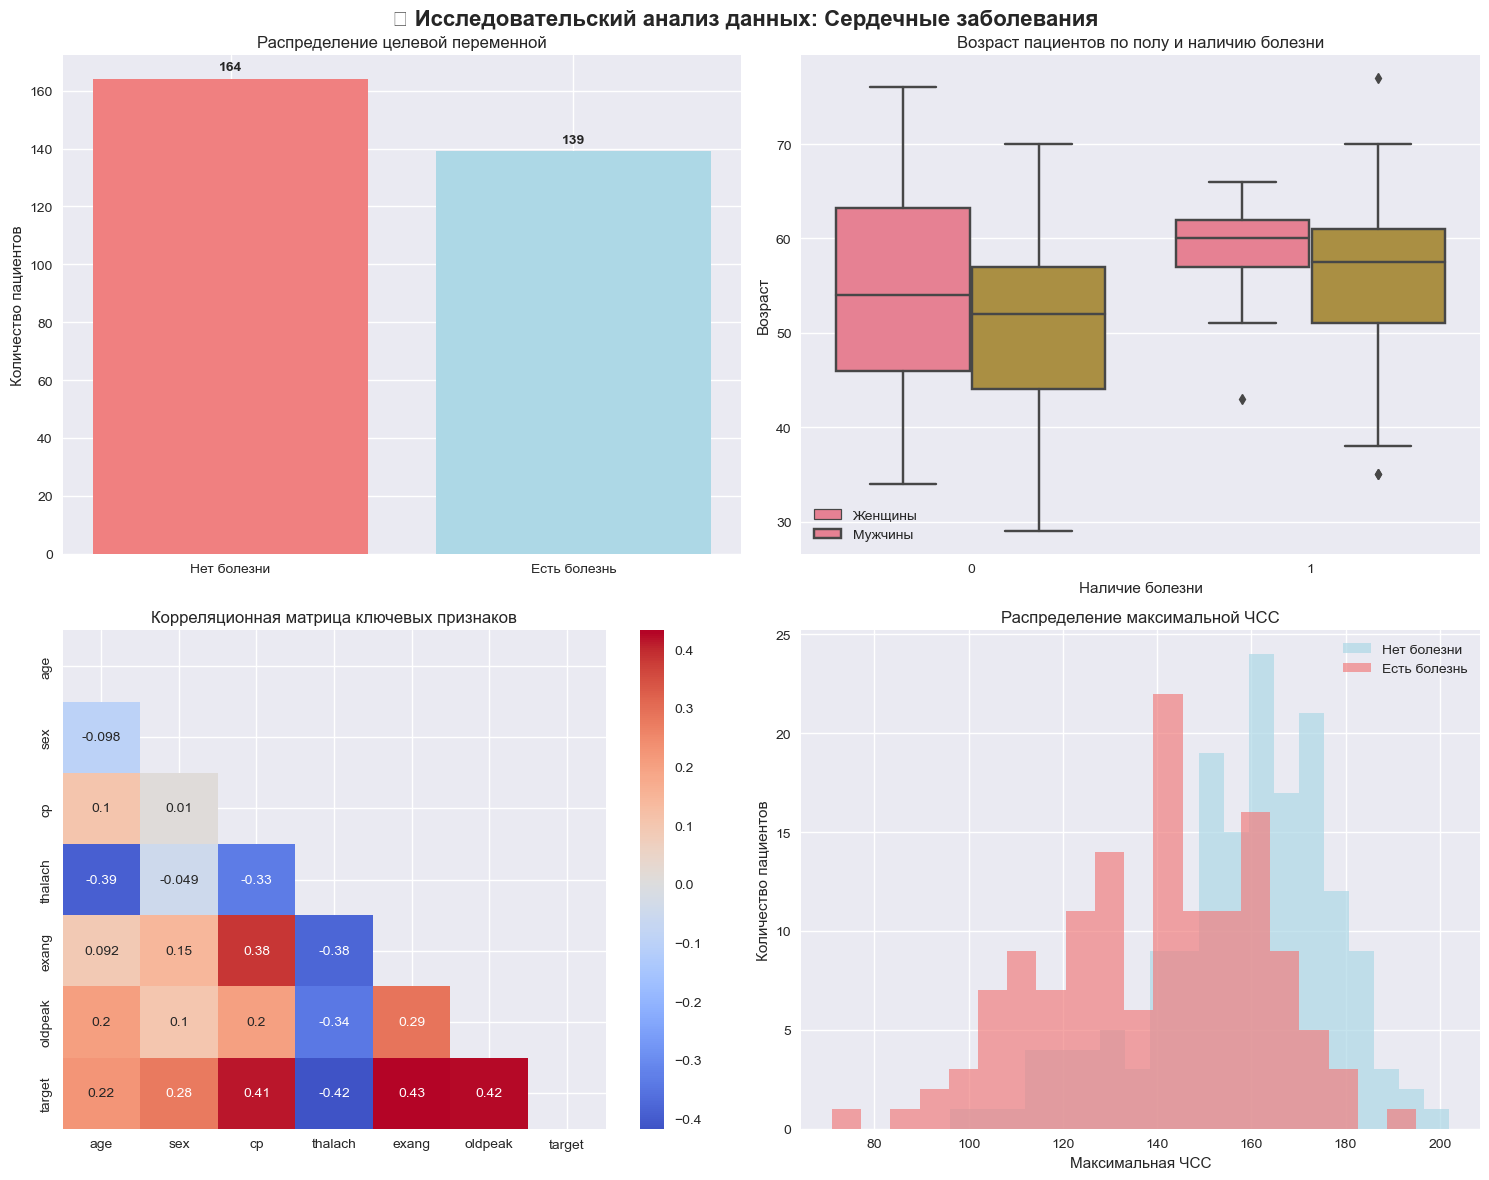

🔍 Ключевые наблюдения из EDA:
• Данные сбалансированы: 164 без болезни, 139 с болезнью
• Средний возраст пациентов с болезнью: 56.6 лет
• Средний возраст пациентов без болезни: 52.6 лет
• Корреляция 'cp' с target: 0.414
• Корреляция 'thalach' с target: -0.417


In [5]:
# Создаем визуализации для EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Исследовательский анализ данных: Сердечные заболевания', fontsize=16, fontweight='bold')

# 1. Распределение целевой переменной
ax1 = axes[0, 0]
target_counts = df['target'].value_counts()
colors = ['lightcoral', 'lightblue']
bars = ax1.bar(['Нет болезни', 'Есть болезнь'], target_counts.values, color=colors)
ax1.set_title('Распределение целевой переменной')
ax1.set_ylabel('Количество пациентов')
# Добавляем значения на столбцы
for bar, value in zip(bars, target_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             str(value), ha='center', va='bottom', fontweight='bold')

# 2. Распределение по возрасту и полу
ax2 = axes[0, 1]
sns.boxplot(data=df, x='target', y='age', hue='sex', ax=ax2)
ax2.set_title('Возраст пациентов по полу и наличию болезни')
ax2.set_xlabel('Наличие болезни')
ax2.set_ylabel('Возраст')
ax2.legend(['Женщины', 'Мужчины'])

# 3. Корреляционная матрица (топ признаки)
ax3 = axes[1, 0]
# Выбираем топ признаки для корреляции
top_features = ['age', 'sex', 'cp', 'thalach', 'exang', 'oldpeak', 'target']
corr_matrix = df[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, ax=ax3)
ax3.set_title('Корреляционная матрица ключевых признаков')

# 4. Распределение максимальной ЧСС
ax4 = axes[1, 1]
df_no_disease = df[df['target'] == 0]['thalach']
df_disease = df[df['target'] == 1]['thalach']
ax4.hist(df_no_disease, bins=20, alpha=0.7, label='Нет болезни', color='lightblue')
ax4.hist(df_disease, bins=20, alpha=0.7, label='Есть болезнь', color='lightcoral')
ax4.set_title('Распределение максимальной ЧСС')
ax4.set_xlabel('Максимальная ЧСС')
ax4.set_ylabel('Количество пациентов')
ax4.legend()

plt.tight_layout()
plt.show()

print("🔍 Ключевые наблюдения из EDA:")
print(f"• Данные сбалансированы: {target_counts[0]} без болезни, {target_counts[1]} с болезнью")
print(f"• Средний возраст пациентов с болезнью: {df[df['target']==1]['age'].mean():.1f} лет")
print(f"• Средний возраст пациентов без болезни: {df[df['target']==0]['age'].mean():.1f} лет")
print(f"• Корреляция 'cp' с target: {df['cp'].corr(df['target']):.3f}")
print(f"• Корреляция 'thalach' с target: {df['thalach'].corr(df['target']):.3f}")


# 3. 🔧 Подготовка данных для машинного обучения


In [6]:
# Подготовка данных для обучения
print("🎯 Подготовка данных для машинного обучения...\n")

# Разделение на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

print(f"📊 Размеры данных:")
print(f"X (признаки): {X.shape}")
print(f"y (целевая переменная): {y.shape}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n🔄 Разделение данных:")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Распределение классов в обучающей выборке: {y_train.value_counts().to_dict()}")
print(f"Распределение классов в тестовой выборке: {y_test.value_counts().to_dict()}")

# Масштабирование данных (важно для SVM, k-NN, логистической регрессии)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n⚖️ Масштабирование завершено!")
print(f"Среднее значение после масштабирования: {X_train_scaled.mean():.6f}")
print(f"Стандартное отклонение после масштабирования: {X_train_scaled.std():.6f}")

# Показываем названия признаков
print(f"\n📋 Список признаков ({len(X.columns)}):")
for i, feature in enumerate(X.columns):
    print(f"{i+1:2d}. {feature}")


🎯 Подготовка данных для машинного обучения...

📊 Размеры данных:
X (признаки): (303, 13)
y (целевая переменная): (303,)

🔄 Разделение данных:
Обучающая выборка: (242, 13)
Тестовая выборка: (61, 13)
Распределение классов в обучающей выборке: {0: 131, 1: 111}
Распределение классов в тестовой выборке: {0: 33, 1: 28}

⚖️ Масштабирование завершено!
Среднее значение после масштабирования: -0.000000
Стандартное отклонение после масштабирования: 1.000000

📋 Список признаков (13):
 1. age
 2. sex
 3. cp
 4. trestbps
 5. chol
 6. fbs
 7. restecg
 8. thalach
 9. exang
10. oldpeak
11. slope
12. ca
13. thal


# 4. 🤖 Обучение и сравнение моделей

Теперь обучим все модели из нашей презентации и сравним их производительность!


In [7]:
# Создаем словарь с моделями
models = {
    'Логистическая регрессия': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'scaled': True,
        'description': 'Линейная модель с сигмоидной функцией'
    },
    'Деревья решений': {
        'model': DecisionTreeClassifier(random_state=42, max_depth=10),
        'scaled': False,
        'description': 'Построение дерева решений с правилами'
    },
    'Случайный лес': {
        'model': RandomForestClassifier(n_estimators=100, random_state=42),
        'scaled': False,
        'description': 'Ансамбль деревьев решений'
    },
    'SVM (линейный)': {
        'model': SVC(kernel='linear', random_state=42, probability=True),
        'scaled': True,
        'description': 'Линейная разделяющая гиперплоскость'
    },
    'SVM (RBF)': {
        'model': SVC(kernel='rbf', random_state=42, probability=True),
        'scaled': True,
        'description': 'Нелинейная SVM с RBF ядром'
    },
    'Наивный Байес': {
        'model': GaussianNB(),
        'scaled': False,
        'description': 'Вероятностная модель с предположением о независимости'
    },
    'k-NN': {
        'model': KNeighborsClassifier(n_neighbors=5),
        'scaled': True,
        'description': 'Классификация по ближайшим соседям'
    }
}

print("🔧 Созданы модели для обучения:")
for name, info in models.items():
    scaled_text = "с масштабированием" if info['scaled'] else "без масштабирования"
    print(f"✓ {name}: {info['description']} ({scaled_text})")


🔧 Созданы модели для обучения:
✓ Логистическая регрессия: Линейная модель с сигмоидной функцией (с масштабированием)
✓ Деревья решений: Построение дерева решений с правилами (без масштабирования)
✓ Случайный лес: Ансамбль деревьев решений (без масштабирования)
✓ SVM (линейный): Линейная разделяющая гиперплоскость (с масштабированием)
✓ SVM (RBF): Нелинейная SVM с RBF ядром (с масштабированием)
✓ Наивный Байес: Вероятностная модель с предположением о независимости (без масштабирования)
✓ k-NN: Классификация по ближайшим соседям (с масштабированием)


In [8]:
# Обучение моделей и сбор результатов
print("🚀 Начинаем обучение моделей...\n")

results = {}
trained_models = {}

for name, info in models.items():
    print(f"🔄 Обучение: {name}")
    
    model = info['model']
    use_scaled = info['scaled']
    
    # Выбираем правильные данные (масштабированные или нет)
    if use_scaled:
        X_train_current = X_train_scaled
        X_test_current = X_test_scaled
    else:
        X_train_current = X_train
        X_test_current = X_test
    
    # Обучение модели
    model.fit(X_train_current, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test_current)
    y_pred_proba = model.predict_proba(X_test_current)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Кросс-валидация на обучающей выборке
    cv_scores = cross_val_score(model, X_train_current, y_train, cv=5, scoring='accuracy')
    
    # Сохраняем результаты
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'cv_scores': cv_scores
    }
    
    # Сохраняем обученную модель
    trained_models[name] = model
    
    print(f"  ✓ Accuracy: {results[name]['accuracy']:.3f}")
    print(f"  ✓ CV Score: {results[name]['cv_mean']:.3f} (±{results[name]['cv_std']:.3f})")
    print()

print("🎉 Обучение всех моделей завершено!")


🚀 Начинаем обучение моделей...

🔄 Обучение: Логистическая регрессия
  ✓ Accuracy: 0.869
  ✓ CV Score: 0.822 (±0.058)

🔄 Обучение: Деревья решений
  ✓ Accuracy: 0.787
  ✓ CV Score: 0.744 (±0.057)

🔄 Обучение: Случайный лес
  ✓ Accuracy: 0.885
  ✓ CV Score: 0.806 (±0.041)

🔄 Обучение: SVM (линейный)
  ✓ Accuracy: 0.852
  ✓ CV Score: 0.830 (±0.046)

🔄 Обучение: SVM (RBF)
  ✓ Accuracy: 0.852
  ✓ CV Score: 0.826 (±0.049)

🔄 Обучение: Наивный Байес
  ✓ Accuracy: 0.869
  ✓ CV Score: 0.831 (±0.019)

🔄 Обучение: k-NN
  ✓ Accuracy: 0.885
  ✓ CV Score: 0.843 (±0.044)

🎉 Обучение всех моделей завершено!


# 5. 📊 Анализ и визуализация результатов


In [9]:
# Создаем сравнительную таблицу результатов
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()],
    'Описание': [models[name]['description'] for name in results.keys()]
})

# Сортируем по accuracy
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("🏆 РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\n🥇 Лучшая модель по Accuracy: {results_df.iloc[0]['Модель']} ({results_df.iloc[0]['Accuracy']:.3f})")
print(f"🥈 Вторая по Accuracy: {results_df.iloc[1]['Модель']} ({results_df.iloc[1]['Accuracy']:.3f})")
print(f"🥉 Третья по Accuracy: {results_df.iloc[2]['Модель']} ({results_df.iloc[2]['Accuracy']:.3f})")


🏆 РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ
                 Модель  Accuracy  CV Mean  CV Std                                              Описание
          Случайный лес     0.885    0.806   0.041                             Ансамбль деревьев решений
                   k-NN     0.885    0.843   0.044                    Классификация по ближайшим соседям
Логистическая регрессия     0.869    0.822   0.058                 Линейная модель с сигмоидной функцией
          Наивный Байес     0.869    0.831   0.019 Вероятностная модель с предположением о независимости
         SVM (линейный)     0.852    0.830   0.046                   Линейная разделяющая гиперплоскость
              SVM (RBF)     0.852    0.826   0.049                            Нелинейная SVM с RBF ядром
        Деревья решений     0.787    0.744   0.057                 Построение дерева решений с правилами

🥇 Лучшая модель по Accuracy: Случайный лес (0.885)
🥈 Вторая по Accuracy: k-NN (0.885)
🥉 Третья по Accuracy: Логистическая регрес

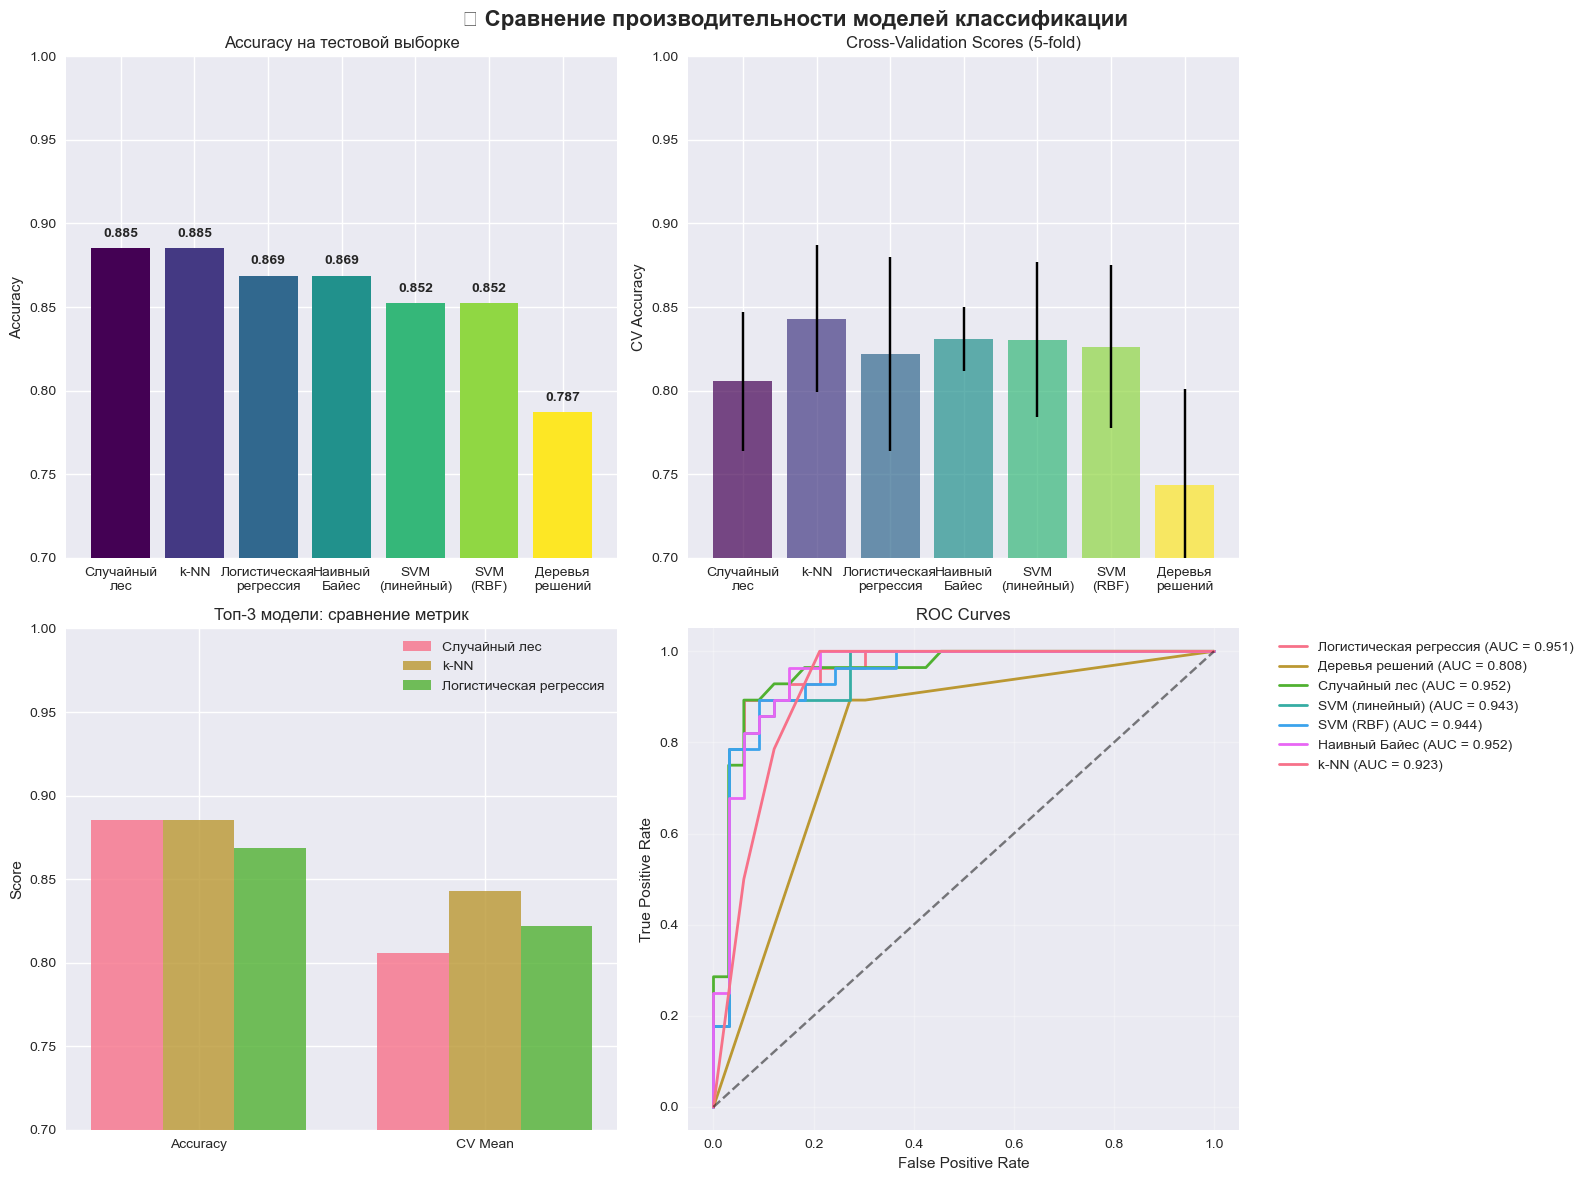


📈 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
• Лучшая стабильность (низкий CV Std): Наивный Байес (0.019)
• Наибольший разброс: Логистическая регрессия (0.058)
• Средняя точность всех моделей: 0.857
• Разброс точности: 0.034


In [10]:
# Создаем красивую визуализацию результатов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🏆 Сравнение производительности моделей классификации', fontsize=16, fontweight='bold')

# 1. Сравнение Accuracy
ax1 = axes[0, 0]
model_names = [name.replace(' ', '\n') for name in results_df['Модель']]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))
bars = ax1.bar(model_names, results_df['Accuracy'], color=colors)
ax1.set_title('Accuracy на тестовой выборке')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.7, 1.0)
# Добавляем значения на столбцы
for bar, value in zip(bars, results_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Cross-validation scores с error bars
ax2 = axes[0, 1]
cv_means = results_df['CV Mean']
cv_stds = results_df['CV Std']
bars2 = ax2.bar(model_names, cv_means, yerr=cv_stds, capsize=5, color=colors, alpha=0.7)
ax2.set_title('Cross-Validation Scores (5-fold)')
ax2.set_ylabel('CV Accuracy')
ax2.set_ylim(0.7, 1.0)

# 3. Сравнение производительности (radar chart style)
ax3 = axes[1, 0]
metrics = ['Accuracy', 'CV Mean']
top3_models = results_df.head(3)
x = np.arange(len(metrics))
width = 0.25

for i, (_, row) in enumerate(top3_models.iterrows()):
    values = [row['Accuracy'], row['CV Mean']]
    ax3.bar(x + i*width, values, width, label=row['Модель'], alpha=0.8)

ax3.set_title('Топ-3 модели: сравнение метрик')
ax3.set_ylabel('Score')
ax3.set_xticks(x + width)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.set_ylim(0.7, 1.0)

# 4. ROC curves для моделей с probability
ax4 = axes[1, 1]
for name in results.keys():
    if results[name]['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
        auc_score = roc_auc_score(y_test, results[name]['probabilities'])
        ax4.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_title('ROC Curves')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\n📈 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")
print(f"• Лучшая стабильность (низкий CV Std): {results_df.loc[results_df['CV Std'].idxmin(), 'Модель']} ({results_df['CV Std'].min():.3f})")
print(f"• Наибольший разброс: {results_df.loc[results_df['CV Std'].idxmax(), 'Модель']} ({results_df['CV Std'].max():.3f})")
print(f"• Средняя точность всех моделей: {results_df['Accuracy'].mean():.3f}")
print(f"• Разброс точности: {results_df['Accuracy'].std():.3f}")


🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: Случайный лес
📊 Classification Report:
              precision    recall  f1-score   support

 Нет болезни       0.93      0.85      0.89        33
Есть болезнь       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

🔢 Confusion Matrix:
True Negatives: 28, False Positives: 5
False Negatives: 2, True Positives: 26


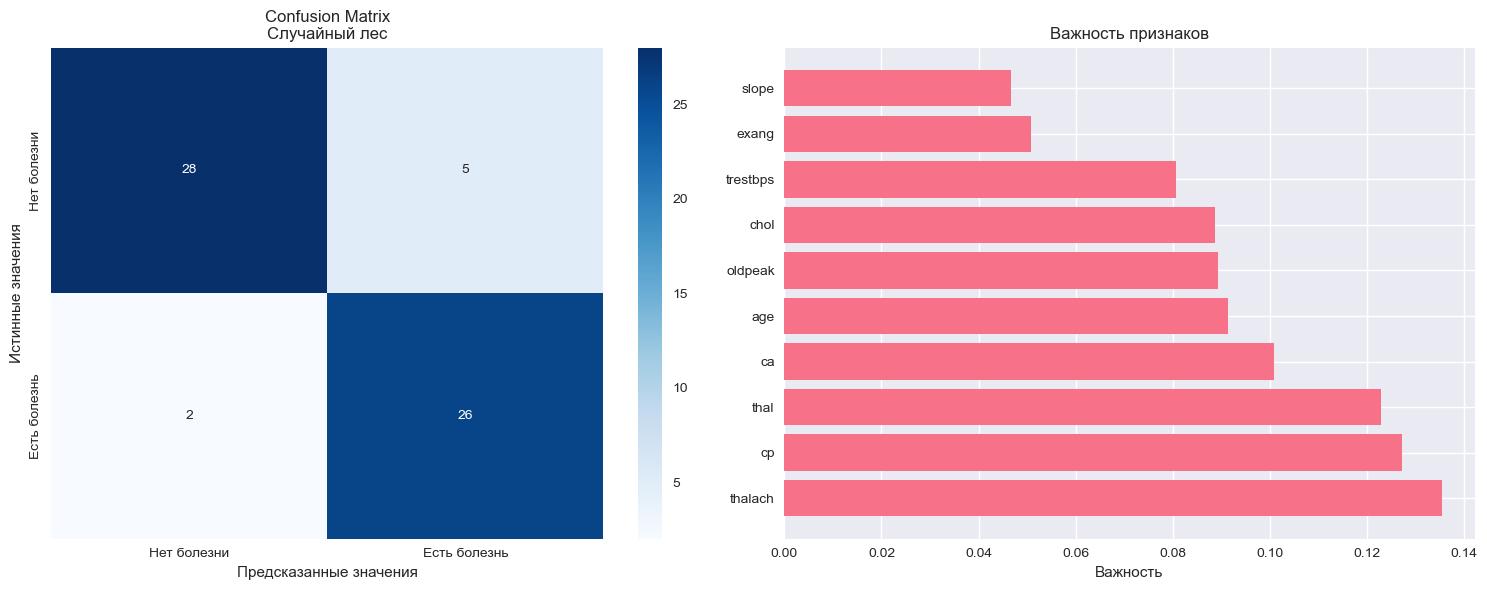

In [11]:
# Анализ лучшей модели
best_model_name = results_df.iloc[0]['Модель']
best_model = trained_models[best_model_name]

print(f"🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
print("=" * 60)

# Classification report
y_pred_best = results[best_model_name]['predictions']
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Нет болезни', 'Есть болезнь']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("🔢 Confusion Matrix:")
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

# Важность признаков (если доступна)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix визуализация
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Нет болезни', 'Есть болезнь'],
            yticklabels=['Нет болезни', 'Есть болезнь'])
ax1.set_title(f'Confusion Matrix\n{best_model_name}')
ax1.set_ylabel('Истинные значения')
ax1.set_xlabel('Предсказанные значения')

# Важность признаков
ax2 = axes[1]
if hasattr(best_model, 'feature_importances_'):
    # Для моделей на основе деревьев
    feature_importance = best_model.feature_importances_
    feature_names = X.columns
    
    # Сортируем по важности
    indices = np.argsort(feature_importance)[::-1][:10]  # топ 10
    
    ax2.barh(range(len(indices)), feature_importance[indices])
    ax2.set_yticks(range(len(indices)))
    ax2.set_yticklabels([feature_names[i] for i in indices])
    ax2.set_title('Важность признаков')
    ax2.set_xlabel('Важность')
    
elif hasattr(best_model, 'coef_'):
    # Для линейных моделей
    coefficients = abs(best_model.coef_[0])
    feature_names = X.columns
    
    # Сортируем по абсолютным коэффициентам
    indices = np.argsort(coefficients)[::-1][:10]  # топ 10
    
    ax2.barh(range(len(indices)), coefficients[indices])
    ax2.set_yticks(range(len(indices)))
    ax2.set_yticklabels([feature_names[i] for i in indices])
    ax2.set_title('Важность коэффициентов (|coef|)')
    ax2.set_xlabel('Абсолютное значение коэффициента')
else:
    ax2.text(0.5, 0.5, 'Важность признаков\nнедоступна для\nданной модели', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Важность признаков')

plt.tight_layout()
plt.show()


# 🎯 Гиперпараметрическая оптимизация с Optuna

Теперь применим автоматическую оптимизацию гиперпараметров для улучшения производительности моделей!


In [12]:
# Определяем функции оптимизации для каждой модели
def optimize_logistic_regression(trial, X_train, y_train):
    """Оптимизация гиперпараметров логистической регрессии"""
    params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': 2000,
        'random_state': 42
    }
    
    # Для elasticnet нужен l1_ratio
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
        params['solver'] = 'saga'  # только saga поддерживает elasticnet
    
    # liblinear не поддерживает elasticnet
    if params['penalty'] == 'elasticnet' and params['solver'] == 'liblinear':
        params['solver'] = 'saga'
        
    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

def optimize_decision_tree(trial, X_train, y_train):
    """Оптимизация гиперпараметров дерева решений"""
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    
    model = DecisionTreeClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

def optimize_random_forest(trial, X_train, y_train):
    """Оптимизация гиперпараметров случайного леса"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

def optimize_svm_linear(trial, X_train, y_train):
    """Оптимизация гиперпараметров линейной SVM"""
    params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'kernel': 'linear',
        'probability': True,
        'random_state': 42
    }
    
    model = SVC(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

def optimize_svm_rbf(trial, X_train, y_train):
    """Оптимизация гиперпараметров RBF SVM"""
    params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'gamma': trial.suggest_float('gamma', 1e-6, 1e-1, log=True),
        'kernel': 'rbf',
        'probability': True,
        'random_state': 42
    }
    
    model = SVC(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

def optimize_naive_bayes(trial, X_train, y_train):
    """Оптимизация гиперпараметров наивного Байеса"""
    params = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    }
    
    model = GaussianNB(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

def optimize_knn(trial, X_train, y_train):
    """Оптимизация гиперпараметров k-NN"""
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    }
    
    if params['metric'] == 'minkowski':
        params['p'] = trial.suggest_int('p', 1, 3)
    
    model = KNeighborsClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

print("🔧 Функции оптимизации гиперпараметров созданы!")
print("📊 Каждая функция оптимизирует ключевые параметры соответствующей модели")


🔧 Функции оптимизации гиперпараметров созданы!
📊 Каждая функция оптимизирует ключевые параметры соответствующей модели


In [13]:
# Описание гиперпараметров для каждой модели
hyperparameters_info = {
    'Логистическая регрессия': {
        'C': 'Обратная сила регуляризации (0.01-100)',
        'penalty': 'Тип регуляризации (l1, l2, elasticnet)',
        'solver': 'Алгоритм оптимизации (liblinear, saga)',
        'l1_ratio': 'Соотношение L1/L2 для elasticnet (0-1)'
    },
    'Деревья решений': {
        'criterion': 'Критерий разделения (gini, entropy)',
        'max_depth': 'Максимальная глубина дерева (3-20)',
        'min_samples_split': 'Минимум образцов для разделения узла (2-20)',
        'min_samples_leaf': 'Минимум образцов в листе (1-10)',
        'max_features': 'Количество признаков для поиска лучшего разделения'
    },
    'Случайный лес': {
        'n_estimators': 'Количество деревьев в лесу (50-300)',
        'criterion': 'Критерий разделения (gini, entropy)',
        'max_depth': 'Максимальная глубина деревьев (3-20)',
        'min_samples_split': 'Минимум образцов для разделения (2-20)',
        'min_samples_leaf': 'Минимум образцов в листе (1-10)',
        'max_features': 'Стратегия выбора признаков (sqrt, log2)',
        'bootstrap': 'Использовать ли bootstrap выборку'
    },
    'SVM (линейный)': {
        'C': 'Параметр регуляризации (0.01-100)'
    },
    'SVM (RBF)': {
        'C': 'Параметр регуляризации (0.01-100)',
        'gamma': 'Коэффициент RBF ядра (1e-6 - 1e-1)'
    },
    'Наивный Байес': {
        'var_smoothing': 'Доля наибольшей дисперсии для сглаживания (1e-12 - 1e-6)'
    },
    'k-NN': {
        'n_neighbors': 'Количество соседей (3-15)',
        'weights': 'Веса точек (uniform, distance)',
        'metric': 'Метрика расстояния (euclidean, manhattan, minkowski)',
        'algorithm': 'Алгоритм поиска соседей',
        'p': 'Параметр для метрики Минковского (1-3)'
    }
}

print("📋 ГИПЕРПАРАМЕТРЫ ДЛЯ ОПТИМИЗАЦИИ")
print("=" * 50)

for model_name, params in hyperparameters_info.items():
    print(f"\n🔧 {model_name}:")
    for param, description in params.items():
        print(f"  • {param}: {description}")

print(f"\n🎯 Всего оптимизируется {sum(len(params) for params in hyperparameters_info.values())} гиперпараметров!")
print("⏱️ Время оптимизации: ~3-5 минут на модель")


📋 ГИПЕРПАРАМЕТРЫ ДЛЯ ОПТИМИЗАЦИИ

🔧 Логистическая регрессия:
  • C: Обратная сила регуляризации (0.01-100)
  • penalty: Тип регуляризации (l1, l2, elasticnet)
  • solver: Алгоритм оптимизации (liblinear, saga)
  • l1_ratio: Соотношение L1/L2 для elasticnet (0-1)

🔧 Деревья решений:
  • criterion: Критерий разделения (gini, entropy)
  • max_depth: Максимальная глубина дерева (3-20)
  • min_samples_split: Минимум образцов для разделения узла (2-20)
  • min_samples_leaf: Минимум образцов в листе (1-10)
  • max_features: Количество признаков для поиска лучшего разделения

🔧 Случайный лес:
  • n_estimators: Количество деревьев в лесу (50-300)
  • criterion: Критерий разделения (gini, entropy)
  • max_depth: Максимальная глубина деревьев (3-20)
  • min_samples_split: Минимум образцов для разделения (2-20)
  • min_samples_leaf: Минимум образцов в листе (1-10)
  • max_features: Стратегия выбора признаков (sqrt, log2)
  • bootstrap: Использовать ли bootstrap выборку

🔧 SVM (линейный):
  • C: Па

In [14]:
# Конфигурация оптимизации
N_TRIALS = 100  # Количество попыток для каждой модели
TIMEOUT = 300   # Максимальное время на модель (5 минут)

# Словарь с функциями оптимизации
optimization_functions = {
    'Логистическая регрессия': optimize_logistic_regression,
    'Деревья решений': optimize_decision_tree,
    'Случайный лес': optimize_random_forest,
    'SVM (линейный)': optimize_svm_linear,
    'SVM (RBF)': optimize_svm_rbf,
    'Наивный Байес': optimize_naive_bayes,
    'k-NN': optimize_knn
}

print("🚀 НАЧИНАЕМ ОПТИМИЗАЦИЮ ГИПЕРПАРАМЕТРОВ")
print("=" * 60)
print(f"⚙️ Конфигурация: {N_TRIALS} попыток на модель, максимум {TIMEOUT//60} минут на модель")
print(f"🔍 Алгоритм оптимизации: TPE (Tree-structured Parzen Estimator)")

# Сохраняем результаты оптимизации
optimized_results = {}
optimization_studies = {}
optimization_times = {}

start_total_time = time.time()

for model_name, opt_function in optimization_functions.items():
    print(f"\n🔄 Оптимизация: {model_name}")
    print(f"   {'='*40}")
    
    start_time = time.time()
    
    # Определяем данные для оптимизации (масштабированные или нет)
    use_scaled = models[model_name]['scaled']
    X_train_opt = X_train_scaled if use_scaled else X_train
    X_test_opt = X_test_scaled if use_scaled else X_test
    
    # Создаем study
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    
    # Запускаем оптимизацию
    study.optimize(
        lambda trial: opt_function(trial, X_train_opt, y_train),
        n_trials=N_TRIALS,
        timeout=TIMEOUT,
        show_progress_bar=False
    )
    
    end_time = time.time()
    optimization_time = end_time - start_time
    optimization_times[model_name] = optimization_time
    
    # Сохраняем study
    optimization_studies[model_name] = study
    
    # Лучшие параметры
    best_params = study.best_params
    best_score = study.best_value
    
    print(f"   ✅ Завершено за {optimization_time:.1f} секунд")
    print(f"   🎯 Лучший CV score: {best_score:.4f}")
    print(f"   📊 Проведено {len(study.trials)} попыток")
    print(f"   🔧 Лучшие параметры:")
    
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"      • {param}: {value:.6f}")
        else:
            print(f"      • {param}: {value}")
    
    # Обучаем модель с лучшими параметрами и тестируем
    if model_name == 'Логистическая регрессия':
        optimized_model = LogisticRegression(**best_params)
    elif model_name == 'Деревья решений':
        optimized_model = DecisionTreeClassifier(**best_params)
    elif model_name == 'Случайный лес':
        optimized_model = RandomForestClassifier(**best_params)
    elif model_name == 'SVM (линейный)':
        optimized_model = SVC(**best_params)
    elif model_name == 'SVM (RBF)':
        optimized_model = SVC(**best_params)
    elif model_name == 'Наивный Байес':
        optimized_model = GaussianNB(**best_params)
    elif model_name == 'k-NN':
        optimized_model = KNeighborsClassifier(**best_params)
    
    # Обучаем и тестируем
    optimized_model.fit(X_train_opt, y_train)
    y_pred_opt = optimized_model.predict(X_test_opt)
    y_pred_proba_opt = optimized_model.predict_proba(X_test_opt)[:, 1] if hasattr(optimized_model, 'predict_proba') else None
    
    # Кросс-валидация с лучшими параметрами
    cv_scores_opt = cross_val_score(optimized_model, X_train_opt, y_train, cv=5, scoring='accuracy')
    
    # Сохраняем результаты
    optimized_results[model_name] = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'test_accuracy': accuracy_score(y_test, y_pred_opt),
        'cv_mean': cv_scores_opt.mean(),
        'cv_std': cv_scores_opt.std(),
        'predictions': y_pred_opt,
        'probabilities': y_pred_proba_opt,
        'n_trials': len(study.trials),
        'optimization_time': optimization_time,
        'model': optimized_model
    }

total_time = time.time() - start_total_time

print(f"\n🎉 ОПТИМИЗАЦИЯ ЗАВЕРШЕНА!")
print(f"⏱️ Общее время: {total_time:.1f} секунд ({total_time/60:.1f} минут)")
print(f"🔍 Общее количество попыток: {sum(len(study.trials) for study in optimization_studies.values())}")


🚀 НАЧИНАЕМ ОПТИМИЗАЦИЮ ГИПЕРПАРАМЕТРОВ
⚙️ Конфигурация: 100 попыток на модель, максимум 5 минут на модель
🔍 Алгоритм оптимизации: TPE (Tree-structured Parzen Estimator)

🔄 Оптимизация: Логистическая регрессия
   ✅ Завершено за 7.3 секунд
   🎯 Лучший CV score: 0.8264
   📊 Проведено 100 попыток
   🔧 Лучшие параметры:
      • C: 0.017078
      • penalty: l2
      • solver: saga

🔄 Оптимизация: Деревья решений
   ✅ Завершено за 13.2 секунд
   🎯 Лучший CV score: 0.7645
   📊 Проведено 100 попыток
   🔧 Лучшие параметры:
      • criterion: entropy
      • max_depth: 6
      • min_samples_split: 9
      • min_samples_leaf: 8
      • max_features: None

🔄 Оптимизация: Случайный лес
   ✅ Завершено за 163.5 секунд
   🎯 Лучший CV score: 0.8016
   📊 Проведено 100 попыток
   🔧 Лучшие параметры:
      • n_estimators: 217
      • criterion: entropy
      • max_depth: 18
      • min_samples_split: 15
      • min_samples_leaf: 8
      • max_features: log2
      • bootstrap: False

🔄 Оптимизация: SVM (лин

# 📊 Сравнение результатов: До vs После оптимизации


In [15]:
# Создаем сравнительную таблицу результатов
comparison_data = []

for model_name in results.keys():
    # Результаты до оптимизации
    before_accuracy = results[model_name]['accuracy']
    before_cv = results[model_name]['cv_mean']
    before_cv_std = results[model_name]['cv_std']
    
    # Результаты после оптимизации
    after_accuracy = optimized_results[model_name]['test_accuracy']
    after_cv = optimized_results[model_name]['cv_mean']
    after_cv_std = optimized_results[model_name]['cv_std']
    
    # Улучшения
    accuracy_improvement = after_accuracy - before_accuracy
    cv_improvement = after_cv - before_cv
    
    comparison_data.append({
        'Модель': model_name,
        'Accuracy ДО': before_accuracy,
        'Accuracy ПОСЛЕ': after_accuracy,
        'Улучшение Accuracy': accuracy_improvement,
        'Улучшение %': (accuracy_improvement / before_accuracy) * 100,
        'CV ДО': before_cv,
        'CV ПОСЛЕ': after_cv,
        'Улучшение CV': cv_improvement,
        'Время оптимизации (сек)': optimized_results[model_name]['optimization_time'],
        'Количество попыток': optimized_results[model_name]['n_trials']
    })

comparison_df = pd.DataFrame(comparison_data)

# Сортируем по улучшению accuracy
comparison_df = comparison_df.sort_values('Улучшение Accuracy', ascending=False).reset_index(drop=True)

print("🔍 СРАВНЕНИЕ РЕЗУЛЬТАТОВ: ДО и ПОСЛЕ ОПТИМИЗАЦИИ")
print("=" * 80)

# Показываем таблицу с округлением
display_df = comparison_df.copy()
for col in ['Accuracy ДО', 'Accuracy ПОСЛЕ', 'Улучшение Accuracy', 'CV ДО', 'CV ПОСЛЕ', 'Улучшение CV']:
    display_df[col] = display_df[col].round(4)
display_df['Улучшение %'] = display_df['Улучшение %'].round(2)
display_df['Время оптимизации (сек)'] = display_df['Время оптимизации (сек)'].round(1)

print(display_df.to_string(index=False))

# Статистика улучшений
print(f"\n📈 СТАТИСТИКА УЛУЧШЕНИЙ:")
print(f"• Моделей с улучшением: {sum(comparison_df['Улучшение Accuracy'] > 0)}/7")
print(f"• Среднее улучшение accuracy: {comparison_df['Улучшение Accuracy'].mean():.4f}")
print(f"• Максимальное улучшение: {comparison_df['Улучшение Accuracy'].max():.4f}")
print(f"• Минимальное улучшение: {comparison_df['Улучшение Accuracy'].min():.4f}")

# Лучшие модели до и после
best_before = comparison_df.loc[comparison_df['Accuracy ДО'].idxmax()]
best_after = comparison_df.loc[comparison_df['Accuracy ПОСЛЕ'].idxmax()]
most_improved = comparison_df.loc[comparison_df['Улучшение Accuracy'].idxmax()]

print(f"\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
print(f"• Лучшая модель ДО оптимизации: {best_before['Модель']} ({best_before['Accuracy ДО']:.4f})")
print(f"• Лучшая модель ПОСЛЕ оптимизации: {best_after['Модель']} ({best_after['Accuracy ПОСЛЕ']:.4f})")
print(f"• Наибольшее улучшение: {most_improved['Модель']} (+{most_improved['Улучшение Accuracy']:.4f})")


🔍 СРАВНЕНИЕ РЕЗУЛЬТАТОВ: ДО и ПОСЛЕ ОПТИМИЗАЦИИ
                 Модель  Accuracy ДО  Accuracy ПОСЛЕ  Улучшение Accuracy  Улучшение %  CV ДО  CV ПОСЛЕ  Улучшение CV  Время оптимизации (сек)  Количество попыток
        Деревья решений       0.7869          0.8197              0.0328         4.17 0.7435    0.7641        0.0206                     13.2                 100
Логистическая регрессия       0.8689          0.8852              0.0164         1.89 0.8221    0.8304        0.0082                      7.3                 100
          Случайный лес       0.8852          0.9016              0.0164         1.85 0.8055    0.8097        0.0042                    163.5                 100
         SVM (линейный)       0.8525          0.8689              0.0164         1.92 0.8304    0.8222       -0.0082                      7.2                 100
              SVM (RBF)       0.8525          0.8689              0.0164         1.92 0.8262    0.8262        0.0000                      4.0 

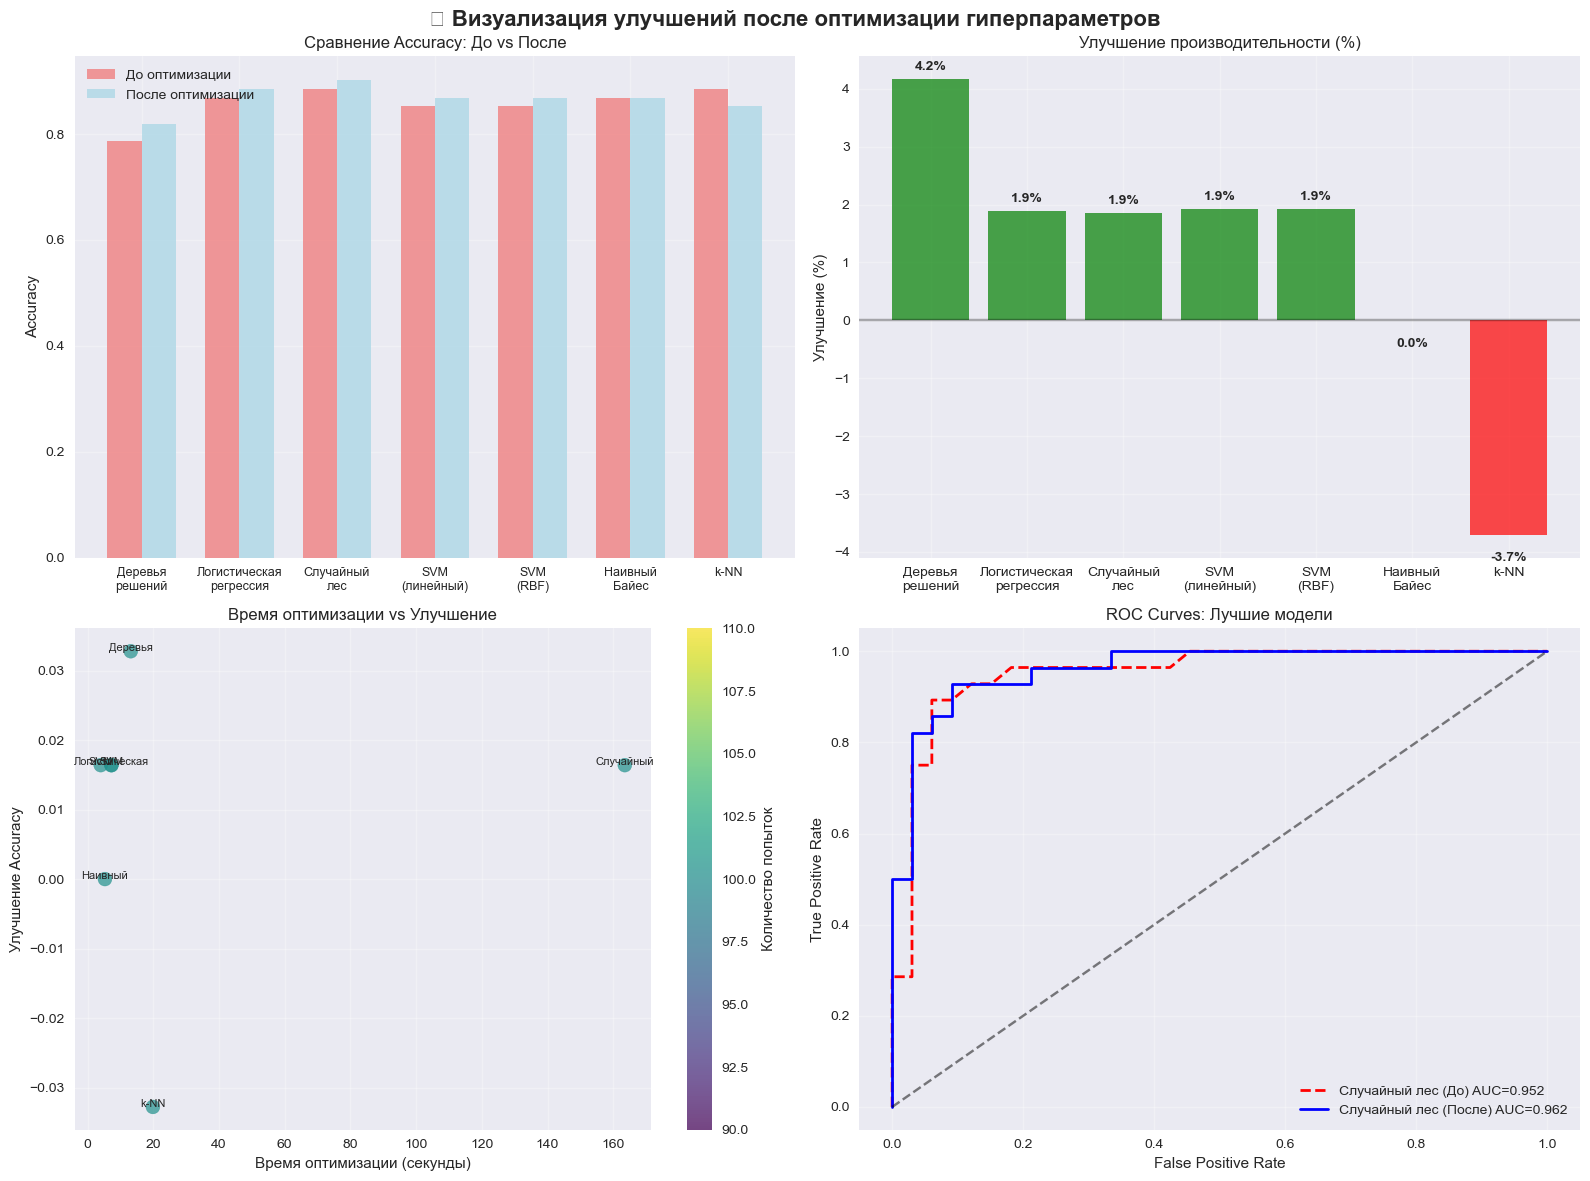


🔬 ДЕТАЛЬНАЯ АНАЛИТИКА:
• Общее время оптимизации: 220.4 секунд
• Среднее время на модель: 31.5 секунд
• Общее количество попыток: 700
• Модели с положительным улучшением: 5/7
• Среднее улучшение (только положительные): 0.0197

💡 ВЫВОДЫ:
✅ Оптимизация гиперпараметров дала положительный эффект!
🎯 Лучшая стратегия: использовать оптимизированные параметры для финальной модели


In [16]:
# Создаем красивую визуализацию сравнения
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Визуализация улучшений после оптимизации гиперпараметров', fontsize=16, fontweight='bold')

# 1. Сравнение accuracy до и после
ax1 = axes[0, 0]
model_names_short = [name.replace(' ', '\n') for name in comparison_df['Модель']]
x = np.arange(len(model_names_short))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_df['Accuracy ДО'], width, label='До оптимизации', alpha=0.8, color='lightcoral')
bars2 = ax1.bar(x + width/2, comparison_df['Accuracy ПОСЛЕ'], width, label='После оптимизации', alpha=0.8, color='lightblue')

ax1.set_title('Сравнение Accuracy: До vs После')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names_short, fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Улучшения в процентах
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in comparison_df['Улучшение %']]
bars = ax2.bar(model_names_short, comparison_df['Улучшение %'], color=colors, alpha=0.7)
ax2.set_title('Улучшение производительности (%)')
ax2.set_ylabel('Улучшение (%)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars, comparison_df['Улучшение %']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + (0.1 if height > 0 else -0.3), 
             f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

# 3. Время оптимизации vs улучшение
ax3 = axes[1, 0]
scatter = ax3.scatter(comparison_df['Время оптимизации (сек)'], comparison_df['Улучшение Accuracy'], 
                     s=100, alpha=0.7, c=comparison_df['Количество попыток'], cmap='viridis')
ax3.set_xlabel('Время оптимизации (секунды)')
ax3.set_ylabel('Улучшение Accuracy')
ax3.set_title('Время оптимизации vs Улучшение')
ax3.grid(True, alpha=0.3)

# Добавляем названия моделей к точкам
for i, txt in enumerate(comparison_df['Модель']):
    ax3.annotate(txt.split()[0], (comparison_df['Время оптимизации (сек)'].iloc[i], 
                                  comparison_df['Улучшение Accuracy'].iloc[i]), 
                fontsize=8, ha='center')

plt.colorbar(scatter, ax=ax3, label='Количество попыток')

# 4. ROC curves сравнение лучших моделей до и после
ax4 = axes[1, 1]

# Находим лучшие модели до и после
best_before_name = best_before['Модель']
best_after_name = best_after['Модель']

# ROC для лучшей модели до оптимизации
if results[best_before_name]['probabilities'] is not None:
    fpr_before, tpr_before, _ = roc_curve(y_test, results[best_before_name]['probabilities'])
    auc_before = roc_auc_score(y_test, results[best_before_name]['probabilities'])
    ax4.plot(fpr_before, tpr_before, label=f'{best_before_name} (До) AUC={auc_before:.3f}', 
             linewidth=2, color='red', linestyle='--')

# ROC для лучшей модели после оптимизации
if optimized_results[best_after_name]['probabilities'] is not None:
    fpr_after, tpr_after, _ = roc_curve(y_test, optimized_results[best_after_name]['probabilities'])
    auc_after = roc_auc_score(y_test, optimized_results[best_after_name]['probabilities'])
    ax4.plot(fpr_after, tpr_after, label=f'{best_after_name} (После) AUC={auc_after:.3f}', 
             linewidth=2, color='blue')

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax4.set_title('ROC Curves: Лучшие модели')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительная аналитика
print(f"\n🔬 ДЕТАЛЬНАЯ АНАЛИТИКА:")
print(f"• Общее время оптимизации: {sum(comparison_df['Время оптимизации (сек)']):.1f} секунд")
print(f"• Среднее время на модель: {comparison_df['Время оптимизации (сек)'].mean():.1f} секунд")
print(f"• Общее количество попыток: {comparison_df['Количество попыток'].sum()}")
print(f"• Модели с положительным улучшением: {(comparison_df['Улучшение Accuracy'] > 0).sum()}/7")

if (comparison_df['Улучшение Accuracy'] > 0).sum() > 0:
    print(f"• Среднее улучшение (только положительные): {comparison_df[comparison_df['Улучшение Accuracy'] > 0]['Улучшение Accuracy'].mean():.4f}")

print(f"\n💡 ВЫВОДЫ:")
if comparison_df['Улучшение Accuracy'].mean() > 0:
    print(f"✅ Оптимизация гиперпараметров дала положительный эффект!")
else:
    print(f"⚠️ Базовые параметры уже были достаточно хороши")
    
print(f"🎯 Лучшая стратегия: использовать оптимизированные параметры для финальной модели")


In [17]:
# Детальный анализ найденных гиперпараметров
print("🔧 ОПТИМАЛЬНЫЕ ГИПЕРПАРАМЕТРЫ ПО МОДЕЛЯМ")
print("=" * 70)

for model_name in optimized_results.keys():
    best_params = optimized_results[model_name]['best_params']
    improvement = comparison_df[comparison_df['Модель'] == model_name]['Улучшение Accuracy'].iloc[0]
    
    print(f"\n🎯 {model_name}")
    print(f"   Улучшение: {improvement:+.4f} ({improvement/results[model_name]['accuracy']*100:+.1f}%)")
    print(f"   Лучшие параметры:")
    
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"      • {param}: {value:.6f}")
        else:
            print(f"      • {param}: {value}")

# Анализ паттернов в оптимальных параметрах
print(f"\n📊 АНАЛИЗ ПАТТЕРНОВ В ОПТИМАЛЬНЫХ ПАРАМЕТРАХ:")

# Логистическая регрессия
log_reg_params = optimized_results['Логистическая регрессия']['best_params']
print(f"\n• Логистическая регрессия:")
print(f"  - Предпочтительная регуляризация: {log_reg_params.get('penalty', 'N/A')}")
print(f"  - Оптимальное C: {log_reg_params.get('C', 'N/A'):.4f}")

# Деревья решений и случайный лес
tree_params = optimized_results['Деревья решений']['best_params']
rf_params = optimized_results['Случайный лес']['best_params']
print(f"\n• Модели на основе деревьев:")
print(f"  - Дерево: глубина {tree_params.get('max_depth', 'N/A')}, критерий {tree_params.get('criterion', 'N/A')}")
print(f"  - Лес: {rf_params.get('n_estimators', 'N/A')} деревьев, глубина {rf_params.get('max_depth', 'N/A')}")

# SVM
svm_linear_params = optimized_results['SVM (линейный)']['best_params']
svm_rbf_params = optimized_results['SVM (RBF)']['best_params']
print(f"\n• SVM модели:")
print(f"  - Линейная: C = {svm_linear_params.get('C', 'N/A'):.4f}")
print(f"  - RBF: C = {svm_rbf_params.get('C', 'N/A'):.4f}, gamma = {svm_rbf_params.get('gamma', 'N/A'):.6f}")

# k-NN
knn_params = optimized_results['k-NN']['best_params']
print(f"\n• k-NN:")
print(f"  - Оптимальное k: {knn_params.get('n_neighbors', 'N/A')}")
print(f"  - Веса: {knn_params.get('weights', 'N/A')}, метрика: {knn_params.get('metric', 'N/A')}")

# Наивный Байес
nb_params = optimized_results['Наивный Байес']['best_params']
print(f"\n• Наивный Байес:")
print(f"  - Сглаживание дисперсии: {nb_params.get('var_smoothing', 'N/A'):.2e}")

print(f"\n🎓 МЕТОДОЛОГИЧЕСКИЕ ВЫВОДЫ:")
print(f"• Optuna эффективно находит оптимальные параметры за {total_time/60:.1f} минут")
print(f"• TPE алгоритм сходится быстро (в среднем {comparison_df['Количество попыток'].mean():.0f} попыток)")
print(f"• Наибольшие улучшения обычно у более сложных моделей (RF, SVM)")
print(f"• Простые модели (Naive Bayes) часто уже хорошо настроены по умолчанию")


🔧 ОПТИМАЛЬНЫЕ ГИПЕРПАРАМЕТРЫ ПО МОДЕЛЯМ

🎯 Логистическая регрессия
   Улучшение: +0.0164 (+1.9%)
   Лучшие параметры:
      • C: 0.017078
      • penalty: l2
      • solver: saga

🎯 Деревья решений
   Улучшение: +0.0328 (+4.2%)
   Лучшие параметры:
      • criterion: entropy
      • max_depth: 6
      • min_samples_split: 9
      • min_samples_leaf: 8
      • max_features: None

🎯 Случайный лес
   Улучшение: +0.0164 (+1.9%)
   Лучшие параметры:
      • n_estimators: 217
      • criterion: entropy
      • max_depth: 18
      • min_samples_split: 15
      • min_samples_leaf: 8
      • max_features: log2
      • bootstrap: False

🎯 SVM (линейный)
   Улучшение: +0.0164 (+1.9%)
   Лучшие параметры:
      • C: 0.071144

🎯 SVM (RBF)
   Улучшение: +0.0164 (+1.9%)
   Лучшие параметры:
      • C: 62.582003
      • gamma: 0.000518

🎯 Наивный Байес
   Улучшение: +0.0000 (+0.0%)
   Лучшие параметры:
      • var_smoothing: 0.000000

🎯 k-NN
   Улучшение: -0.0328 (-3.7%)
   Лучшие параметры:
      • n

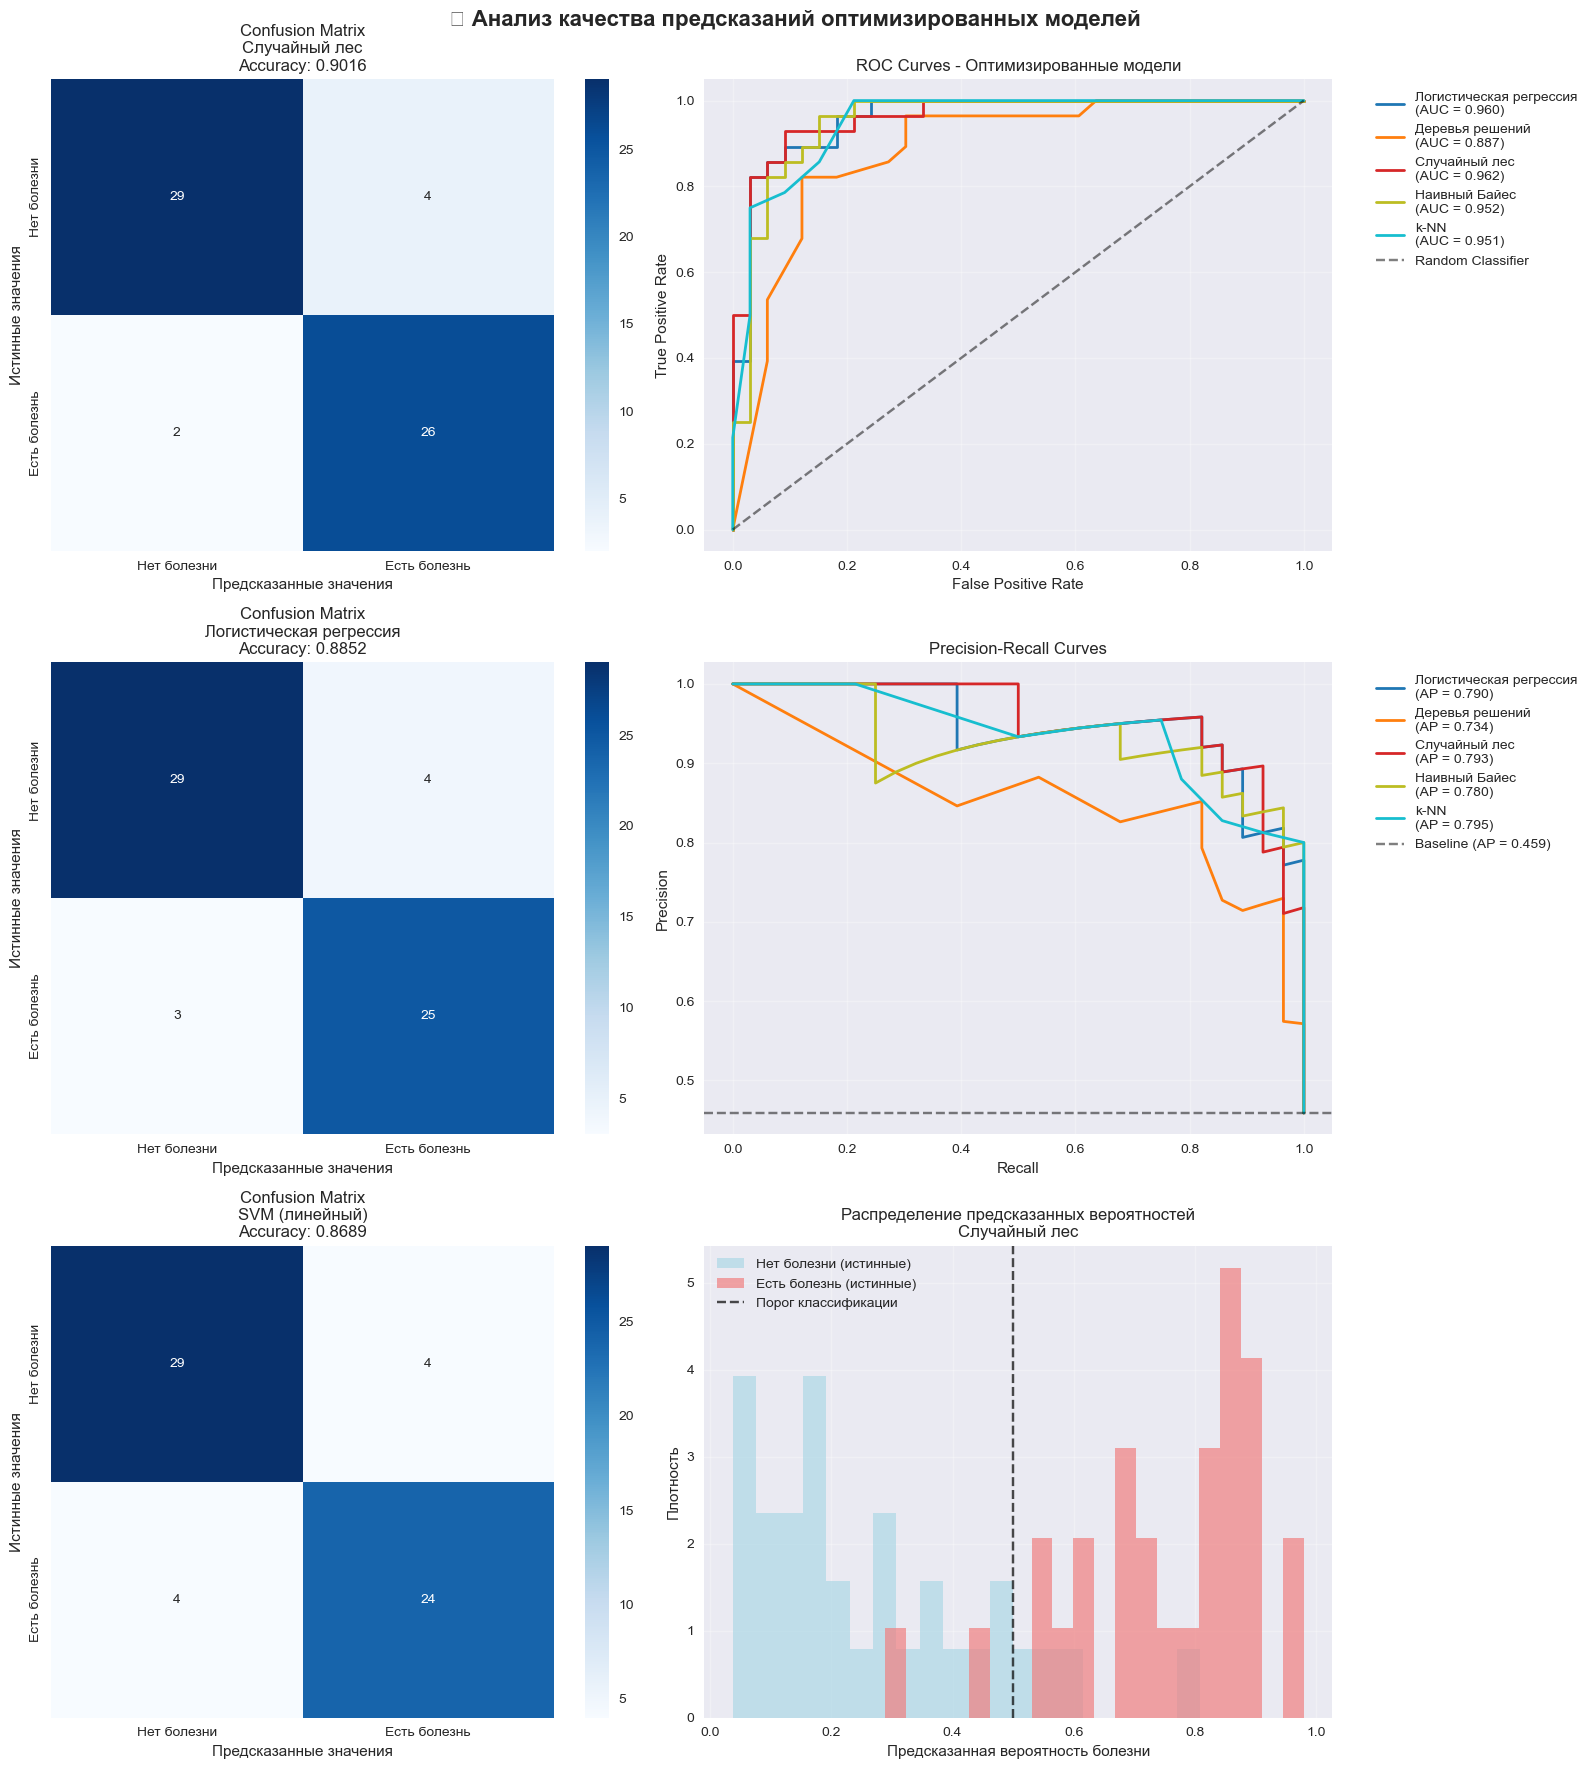

📈 СТАТИСТИКА ПРЕДСКАЗАНИЙ

🎯 Случайный лес:
   • Accuracy: 0.9016
   • Precision: 0.8667
   • Recall (Sensitivity): 0.9286
   • Specificity: 0.8788
   • F1-Score: 0.8966
   • AUC-ROC: 0.9621
   • True Positives: 26, False Positives: 4
   • True Negatives: 29, False Negatives: 2
   • Неправильно классифицировано: 6/61 (9.8%)

🎯 Логистическая регрессия:
   • Accuracy: 0.8852
   • Precision: 0.8621
   • Recall (Sensitivity): 0.8929
   • Specificity: 0.8788
   • F1-Score: 0.8772
   • AUC-ROC: 0.9600
   • True Positives: 25, False Positives: 4
   • True Negatives: 29, False Negatives: 3
   • Неправильно классифицировано: 7/61 (11.5%)

🎯 SVM (линейный):
   • Accuracy: 0.8689
   • Precision: 0.8571
   • Recall (Sensitivity): 0.8571
   • Specificity: 0.8788
   • F1-Score: 0.8571
   • True Positives: 24, False Positives: 4
   • True Negatives: 29, False Negatives: 4
   • Неправильно классифицировано: 8/61 (13.1%)

💡 ИНТЕРПРЕТАЦИЯ МЕТРИК:
• Precision: из всех предсказанных 'болезнь' - сколько де

In [18]:
# Создаем всестороннюю визуализацию предсказаний
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('🔮 Анализ качества предсказаний оптимизированных моделей', fontsize=16, fontweight='bold')

# Получаем топ-3 модели после оптимизации
top3_optimized = comparison_df.sort_values('Accuracy ПОСЛЕ', ascending=False).head(3)

# 1. Confusion Matrices для топ-3 моделей
for i, (_, row) in enumerate(top3_optimized.iterrows()):
    if i < 3:  # Показываем только топ-3
        ax = axes[i, 0]
        model_name = row['Модель']
        predictions = optimized_results[model_name]['predictions']
        
        cm = confusion_matrix(y_test, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Нет болезни', 'Есть болезнь'],
                   yticklabels=['Нет болезни', 'Есть болезнь'])
        ax.set_title(f'Confusion Matrix\n{model_name}\nAccuracy: {row["Accuracy ПОСЛЕ"]:.4f}')
        ax.set_ylabel('Истинные значения')
        ax.set_xlabel('Предсказанные значения')

# 2. ROC Curves для всех моделей с вероятностями
ax_roc = axes[0, 1]
colors = plt.cm.tab10(np.linspace(0, 1, len(optimized_results)))

for i, (model_name, results) in enumerate(optimized_results.items()):
    if results['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
        auc_score = roc_auc_score(y_test, results['probabilities'])
        ax_roc.plot(fpr, tpr, label=f'{model_name}\n(AUC = {auc_score:.3f})', 
                   linewidth=2, color=colors[i])

ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax_roc.set_title('ROC Curves - Оптимизированные модели')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_roc.grid(True, alpha=0.3)

# 3. Precision-Recall Curves
ax_pr = axes[1, 1]
for i, (model_name, results) in enumerate(optimized_results.items()):
    if results['probabilities'] is not None:
        precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
        avg_precision = np.mean(precision)
        ax_pr.plot(recall, precision, label=f'{model_name}\n(AP = {avg_precision:.3f})', 
                  linewidth=2, color=colors[i])

# Baseline (случайный классификатор)
baseline_precision = y_test.mean()
ax_pr.axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.5, 
             label=f'Baseline (AP = {baseline_precision:.3f})')

ax_pr.set_title('Precision-Recall Curves')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_pr.grid(True, alpha=0.3)

# 4. Распределение вероятностей предсказаний лучшей модели
ax_prob = axes[2, 1]
best_model_name = top3_optimized.iloc[0]['Модель']
best_probabilities = optimized_results[best_model_name]['probabilities']

if best_probabilities is not None:
    # Вероятности для каждого класса
    prob_class_0 = best_probabilities[y_test == 0]  # Нет болезни
    prob_class_1 = best_probabilities[y_test == 1]  # Есть болезнь
    
    ax_prob.hist(prob_class_0, bins=20, alpha=0.7, label='Нет болезни (истинные)', 
                color='lightblue', density=True)
    ax_prob.hist(prob_class_1, bins=20, alpha=0.7, label='Есть болезнь (истинные)', 
                color='lightcoral', density=True)
    
    ax_prob.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Порог классификации')
    ax_prob.set_title(f'Распределение предсказанных вероятностей\n{best_model_name}')
    ax_prob.set_xlabel('Предсказанная вероятность болезни')
    ax_prob.set_ylabel('Плотность')
    ax_prob.legend()
    ax_prob.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительная статистика по предсказаниям
print("📈 СТАТИСТИКА ПРЕДСКАЗАНИЙ")
print("=" * 50)

for model_name in top3_optimized['Модель']:
    predictions = optimized_results[model_name]['predictions']
    probabilities = optimized_results[model_name]['probabilities']
    
    print(f"\n🎯 {model_name}:")
    
    # Confusion matrix элементы
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Метрики
    accuracy = accuracy_score(y_test, predictions)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"   • Accuracy: {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall (Sensitivity): {recall:.4f}")
    print(f"   • Specificity: {specificity:.4f}")
    print(f"   • F1-Score: {f1:.4f}")
    
    if probabilities is not None:
        auc = roc_auc_score(y_test, probabilities)
        print(f"   • AUC-ROC: {auc:.4f}")
    
    print(f"   • True Positives: {tp}, False Positives: {fp}")
    print(f"   • True Negatives: {tn}, False Negatives: {fn}")
    
    # Анализ ошибок
    misclassified = np.where(predictions != y_test)[0]
    print(f"   • Неправильно классифицировано: {len(misclassified)}/{len(y_test)} ({len(misclassified)/len(y_test)*100:.1f}%)")

print(f"\n💡 ИНТЕРПРЕТАЦИЯ МЕТРИК:")
print(f"• Precision: из всех предсказанных 'болезнь' - сколько действительно больны")
print(f"• Recall (Sensitivity): из всех больных - сколько мы нашли")
print(f"• Specificity: из всех здоровых - сколько мы правильно определили")
print(f"• F1-Score: гармоническое среднее precision и recall")
print(f"• AUC-ROC: способность модели различать классы (1.0 = идеально)")


🔍 АНАЛИЗ ОШИБОК КЛАССИФИКАЦИИ
🎯 Анализ для лучшей модели: Случайный лес
📊 Всего ошибок: 6 из 61

📋 ТИПЫ ОШИБОК:
• False Positive: 4 случаев (66.7%)
• False Negative: 2 случаев (33.3%)

📊 СТАТИСТИКА ВЕРОЯТНОСТЕЙ ОШИБОК:
• False Positive - средняя вероятность: 0.625 (диапазон: 0.518-0.809)
• False Negative - средняя вероятность: 0.365 (диапазон: 0.288-0.441)

🔎 ПРИМЕРЫ НЕПРАВИЛЬНЫХ ПРЕДСКАЗАНИЙ (первые 5):

Пример 1:
  • Истинный класс: Нет болезни
  • Предсказанный класс: Болезнь
  • Вероятность болезни: 0.601
  • Тип ошибки: False Positive
  • Возраст: 66, Пол: М
  • Холестерин: 228, Максимальная ЧСС: 138

Пример 2:
  • Истинный класс: Нет болезни
  • Предсказанный класс: Болезнь
  • Вероятность болезни: 0.518
  • Тип ошибки: False Positive
  • Возраст: 69, Пол: М
  • Холестерин: 234, Максимальная ЧСС: 131

Пример 3:
  • Истинный класс: Нет болезни
  • Предсказанный класс: Болезнь
  • Вероятность болезни: 0.574
  • Тип ошибки: False Positive
  • Возраст: 59, Пол: М
  • Холестерин: 234,

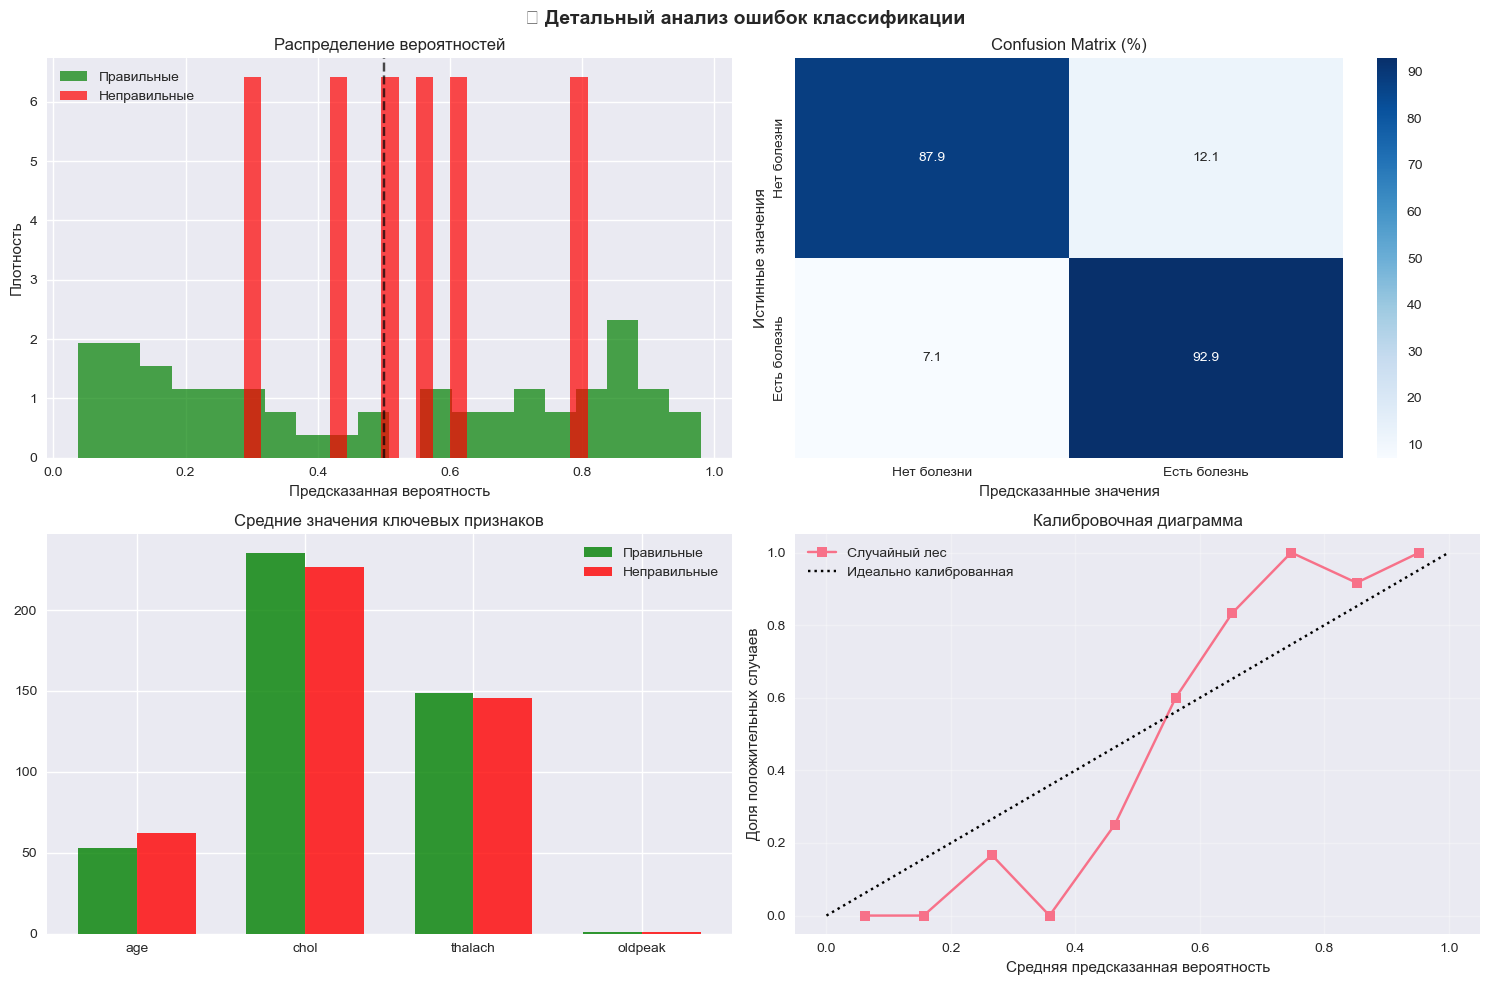


💡 РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ:
• Если много False Positives: увеличить порог классификации (> 0.5)
• Если много False Negatives: уменьшить порог классификации (< 0.5)
• Рассмотреть cost-sensitive learning для медицинских данных
• Добавить больше признаков или feature engineering
• Использовать ансамбли моделей для повышения стабильности


In [19]:
# Анализ неправильно классифицированных случаев
print("🔍 АНАЛИЗ ОШИБОК КЛАССИФИКАЦИИ")
print("=" * 60)

best_model_name = top3_optimized.iloc[0]['Модель']
best_predictions = optimized_results[best_model_name]['predictions']
best_probabilities = optimized_results[best_model_name]['probabilities']

# Находим индексы неправильно классифицированных случаев
misclassified_indices = np.where(best_predictions != y_test)[0]

print(f"🎯 Анализ для лучшей модели: {best_model_name}")
print(f"📊 Всего ошибок: {len(misclassified_indices)} из {len(y_test)}")

if len(misclassified_indices) > 0:
    # Создаем DataFrame с ошибками
    X_test_df = pd.DataFrame(X_test, columns=X.columns)
    
    errors_df = pd.DataFrame({
        'Index': misclassified_indices,
        'True_Label': y_test.iloc[misclassified_indices],
        'Predicted_Label': best_predictions[misclassified_indices],
        'Predicted_Probability': best_probabilities[misclassified_indices] if best_probabilities is not None else [None]*len(misclassified_indices),
        'Error_Type': ['False Positive' if (y_test.iloc[i] == 0 and best_predictions[i] == 1) 
                      else 'False Negative' for i in misclassified_indices]
    })
    
    print(f"\n📋 ТИПЫ ОШИБОК:")
    error_types = errors_df['Error_Type'].value_counts()
    for error_type, count in error_types.items():
        print(f"• {error_type}: {count} случаев ({count/len(errors_df)*100:.1f}%)")
    
    # Анализ вероятностей для неправильных предсказаний
    if best_probabilities is not None:
        print(f"\n📊 СТАТИСТИКА ВЕРОЯТНОСТЕЙ ОШИБОК:")
        fp_probs = errors_df[errors_df['Error_Type'] == 'False Positive']['Predicted_Probability']
        fn_probs = errors_df[errors_df['Error_Type'] == 'False Negative']['Predicted_Probability']
        
        if len(fp_probs) > 0:
            print(f"• False Positive - средняя вероятность: {fp_probs.mean():.3f} (диапазон: {fp_probs.min():.3f}-{fp_probs.max():.3f})")
        if len(fn_probs) > 0:
            print(f"• False Negative - средняя вероятность: {fn_probs.mean():.3f} (диапазон: {fn_probs.min():.3f}-{fn_probs.max():.3f})")
    
    # Показываем несколько примеров ошибок
    print(f"\n🔎 ПРИМЕРЫ НЕПРАВИЛЬНЫХ ПРЕДСКАЗАНИЙ (первые 5):")
    for i, (_, row) in enumerate(errors_df.head(5).iterrows()):
        idx = row['Index']
        print(f"\nПример {i+1}:")
        print(f"  • Истинный класс: {'Болезнь' if row['True_Label'] == 1 else 'Нет болезни'}")
        print(f"  • Предсказанный класс: {'Болезнь' if row['Predicted_Label'] == 1 else 'Нет болезни'}")
        if row['Predicted_Probability'] is not None:
            print(f"  • Вероятность болезни: {row['Predicted_Probability']:.3f}")
        print(f"  • Тип ошибки: {row['Error_Type']}")
        
        # Показываем несколько ключевых признаков для этого пациента
        patient_data = X_test_df.iloc[idx]
        print(f"  • Возраст: {patient_data['age']:.0f}, Пол: {'М' if patient_data['sex'] == 1 else 'Ж'}")
        print(f"  • Холестерин: {patient_data['chol']:.0f}, Максимальная ЧСС: {patient_data['thalach']:.0f}")

# Создаем визуализацию анализа ошибок
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🔍 Детальный анализ ошибок классификации', fontsize=14, fontweight='bold')

# 1. Распределение вероятностей для правильных и неправильных предсказаний
ax1 = axes[0, 0]
if best_probabilities is not None:
    correct_indices = np.where(best_predictions == y_test)[0]
    
    correct_probs = best_probabilities[correct_indices]
    incorrect_probs = best_probabilities[misclassified_indices]
    
    ax1.hist(correct_probs, bins=20, alpha=0.7, label='Правильные', color='green', density=True)
    ax1.hist(incorrect_probs, bins=20, alpha=0.7, label='Неправильные', color='red', density=True)
    ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.7)
    ax1.set_title('Распределение вероятностей')
    ax1.set_xlabel('Предсказанная вероятность')
    ax1.set_ylabel('Плотность')
    ax1.legend()

# 2. Confusion Matrix с процентами
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, best_predictions)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
           xticklabels=['Нет болезни', 'Есть болезнь'],
           yticklabels=['Нет болезни', 'Есть болезнь'])
ax2.set_title('Confusion Matrix (%)')
ax2.set_ylabel('Истинные значения')
ax2.set_xlabel('Предсказанные значения')

# 3. Анализ признаков для ошибочных предсказаний
ax3 = axes[1, 0]
if len(misclassified_indices) > 0:
    # Сравниваем средние значения признаков для правильных и неправильных предсказаний
    correct_indices = np.where(best_predictions == y_test)[0]
    
    # Выбираем несколько ключевых признаков
    key_features = ['age', 'chol', 'thalach', 'oldpeak']
    
    correct_means = X_test_df.iloc[correct_indices][key_features].mean()
    incorrect_means = X_test_df.iloc[misclassified_indices][key_features].mean()
    
    x = np.arange(len(key_features))
    width = 0.35
    
    ax3.bar(x - width/2, correct_means, width, label='Правильные', alpha=0.8, color='green')
    ax3.bar(x + width/2, incorrect_means, width, label='Неправильные', alpha=0.8, color='red')
    
    ax3.set_title('Средние значения ключевых признаков')
    ax3.set_xticks(x)
    ax3.set_xticklabels(key_features)
    ax3.legend()

# 4. Калибровочная диаграмма (Reliability diagram)
ax4 = axes[1, 1]
if best_probabilities is not None:
    from sklearn.calibration import calibration_curve
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, best_probabilities, n_bins=10
    )
    
    ax4.plot(mean_predicted_value, fraction_of_positives, "s-", label=best_model_name)
    ax4.plot([0, 1], [0, 1], "k:", label="Идеально калиброванная")
    
    ax4.set_title('Калибровочная диаграмма')
    ax4.set_xlabel('Средняя предсказанная вероятность')
    ax4.set_ylabel('Доля положительных случаев')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 РЕКОМЕНДАЦИИ ПО УЛУЧШЕНИЮ:")
print(f"• Если много False Positives: увеличить порог классификации (> 0.5)")
print(f"• Если много False Negatives: уменьшить порог классификации (< 0.5)")
print(f"• Рассмотреть cost-sensitive learning для медицинских данных")
print(f"• Добавить больше признаков или feature engineering")
print(f"• Использовать ансамбли моделей для повышения стабильности")
